In [1]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import ot
import timeit
import time
import warnings
import pandas as pd
import re
import os
import math

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import gridspec

from scipy import stats
from scipy.stats import poisson, beta, linregress, skewnorm, hypergeom
from scipy.stats import chi2, nbinom, gamma, binom
from scipy.spatial import distance


warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


In [2]:

def get_distribution(name):
    """Return scipy.stats distribution based on string name."""
    dist_map = {
        'poisson': poisson,
        'chi2': chi2,
        'nbinom': nbinom,
        'gamma': gamma,
        'binom': binom,
        'hypergeom': hypergeom,
        'skewnorm': skewnorm,
    }
    return dist_map.get(name.lower(), None)


def is_discrete(dist_name):
    """Return True if distribution is discrete, else False."""
    discrete_dists = {'poisson', 'nbinom', 'binom'}
    return dist_name.lower() in discrete_dists


def find_optimal_mass_cutoff(dist_name, param, tolerance=0.01):
    """
    Finds highest mass cutoff s.t. truncated distribution approximates
    mean, variance, skewness, kurtosis within tolerance.
    """
    dist_name = dist_name.lower()
    dist = get_distribution(dist_name)
    if dist is None:
        raise ValueError(f"Distribution '{dist_name}' not supported.")
    
    # Create distribution object with params:
    if is_discrete(dist_name):
        # param is tuple for binom and nbinom, scalar for poisson
        if dist_name == 'poisson':
            dist_obj = dist(mu=float(param))
        else:
            dist_obj = dist(*param)
    else:
        # continuous
        dist_obj = dist(*param) if isinstance(param, (list, tuple)) else dist(param)
    
    full_mean = dist_obj.mean()
    full_var = dist_obj.var()
    full_skew = dist_obj.stats(moments='s')
    full_kurt = dist_obj.stats(moments='k')
    
    mass_cutoffs = np.linspace(0.9999, 0.9999999999, 500)
    
    for m in mass_cutoffs:
        lower_q = (1 - m) / 2
        upper_q = 1 - lower_q
        
        # Get truncation bounds
        L = dist_obj.ppf(lower_q)
        U = dist_obj.ppf(upper_q)
        
        # Adjust bounds for discrete vs continuous
        if is_discrete(dist_name):
            L = int(np.floor(L))
            U = int(np.ceil(U))
            support = np.arange(L, U + 1)
            pmf = dist_obj.pmf(support)
            total_mass = np.sum(pmf)
            if total_mass == 0:
                continue
            norm_pmf = pmf / total_mass
            mean = np.sum(support * norm_pmf)
            var = np.sum((support - mean)**2 * norm_pmf)
            std = np.sqrt(var)
            skew = np.sum((support - mean)**3 * norm_pmf) / std**3 if std > 0 else 0
            kurt = np.sum((support - mean)**4 * norm_pmf) / std**4 - 3 if std > 0 else 0
        else:
            # Continuous case
            cdf_L = dist_obj.cdf(L)
            cdf_U = dist_obj.cdf(U)
            mass = cdf_U - cdf_L
            if mass == 0:
                continue
            
            # Truncated mean
            mean = dist_obj.expect(lambda x: x, lb=L, ub=U) / mass
            var = dist_obj.expect(lambda x: (x - mean)**2, lb=L, ub=U) / mass
            std = np.sqrt(var)
            skew = dist_obj.expect(lambda x: (x - mean)**3, lb=L, ub=U) / mass / std**3 if std > 0 else 0
            kurt = dist_obj.expect(lambda x: (x - mean)**4, lb=L, ub=U) / mass / std**4 - 3 if std > 0 else 0

        # Check relative tolerance for all moments
        if all([
            abs(mean - full_mean) / full_mean < tolerance,
            abs(var - full_var) / full_var < tolerance,
            abs(skew - full_skew) / abs(full_skew) < tolerance if full_skew != 0 else True,
            abs(kurt - full_kurt) / abs(full_kurt) < tolerance if full_kurt != 0 else True,
        ]):
            return m

    return 0.999999999


def s_window_shift_and_skew(dist_name, param, mass_cutoff):
    """
    Computes Shift (𝒮), skewness, kurtosis, L, U, truncated mean and optionally variance.
    """
    dist_name = dist_name.lower()
    dist = get_distribution(dist_name)
    if dist is None:
        raise ValueError(f"Distribution '{dist_name}' not supported.")

    if is_discrete(dist_name):
        dist_obj = dist(mu=float(param)) if dist_name == 'poisson' else dist(*param)
    else:
        dist_obj = dist(*param) if isinstance(param, (list, tuple)) else dist(param)

    lower_q = (1 - mass_cutoff) / 2
    upper_q = 1 - lower_q

    try:
        L = dist_obj.ppf(lower_q)
        U = dist_obj.ppf(upper_q)
    except Exception:
        return (0, 0, 0, 0, 0, 0, 0)
        
    if is_discrete(dist_name):
        L = int(np.floor(L))
        U = int(np.ceil(U))
        if L >= U:
            return (0, 0, 0, L, U, 0, 0)
            
        support = np.arange(L, U + 1)
        pmf = dist_obj.pmf(support)
        total_mass = np.sum(pmf)

        if total_mass == 0:
            return (0, 0, 0, L, U, 0, 0)
            
        norm_pmf = pmf / total_mass
        mean_trunc = np.sum(support * norm_pmf)
        var_trunc = np.sum((support - mean_trunc)**2 * norm_pmf)
        std = np.sqrt(var_trunc)
        skew = np.sum((support - mean_trunc)**3 * norm_pmf) / std**3 if std > 0 else 0
        kurt = np.sum((support - mean_trunc)**4 * norm_pmf) / std**4 - 3 if std > 0 else 0
        shift = (U - mean_trunc) / (U - L) if U > L else 0
    else:
        # continuous
        if L >= U:
            return (0, 0, 0, L, U, 0, 0)
            
        cdf_L = dist_obj.cdf(L)
        cdf_U = dist_obj.cdf(U)
        mass = cdf_U - cdf_L
        if mass == 0:
            return (0, 0, 0, L, U, 0, 0)
            
        mean_trunc = dist_obj.expect(lambda x: x, lb=L, ub=U) / mass
        var_trunc = dist_obj.expect(lambda x: (x - mean_trunc)**2, lb=L, ub=U) / mass
        std = np.sqrt(var_trunc)
        skew = dist_obj.expect(lambda x: (x - mean_trunc)**3, lb=L, ub=U) / mass / std**3 if std > 0 else 0
        kurt = dist_obj.expect(lambda x: (x - mean_trunc)**4, lb=L, ub=U) / mass / std**4 - 3 if std > 0 else 0
        shift = (U - mean_trunc) / (U - L) if U > L else 0

    return shift, skew, kurt, L, U, mean_trunc, var_trunc
    

In [3]:

fs = 12

# Lambda values
lambdas = np.logspace(-3, 6, 100)

# Optimal mass cutoff
mass_cutoff = find_optimal_mass_cutoff('poisson', 10000)
print('Optimal mass cutoff for Poisson:', mass_cutoff)

# Storage
shift_vals = []
skew_vals = []
kurt_vals = []
means = []
vars_ = []

# Compute stats
for lam in lambdas:
    shift, skew, kurt, L, U, mean, var = s_window_shift_and_skew('poisson', lam, mass_cutoff)
    shift_vals.append(shift)
    skew_vals.append(skew)
    kurt_vals.append(kurt)
    means.append(mean)
    vars_.append(var)

# Ground truth
true_means = np.array(lambdas)
true_vars = true_means
true_skews = 1 / np.sqrt(true_means)
true_kurts = 1 / true_means  # excess kurtosis

# Convert lists to arrays
means = np.array(means)
vars_ = np.array(vars_)
skew_vals = np.array(skew_vals)
kurt_vals = np.array(kurt_vals)
shift_vals = np.array(shift_vals)

poisson_shift_vals = list(shift_vals)
poisson_skew_vals = list(skew_vals)

poisson_text = r'$10^{-3} ≤ \lambda ≤ 10^{6}$'


Optimal mass cutoff for Poisson: 0.9999999999


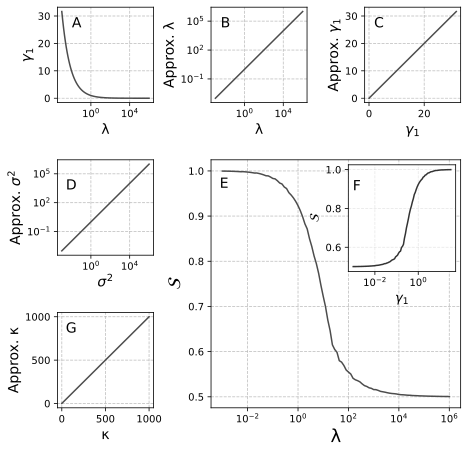

In [4]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# === Plotting ===
fig = plt.figure(figsize=(10, 10))
gs = gridspec.GridSpec(4, 4)

# Font size for main plots
fs = 14

# Skewness vs True Mean (top-left)
ax_center = fig.add_subplot(gs[0, 0])
ax_center.plot(true_means, true_skews, color='0.3')
ax_center.grid(True, linestyle='--', alpha=0.8)
ax_center.set_xscale('log')
ax_center.set_xlabel("λ", fontsize=fs)
ax_center.set_ylabel(r"$γ_{1}$", fontsize=fs)
ax_center.tick_params(which='both', labelsize=fs-4)
ax_center.text(0.25, 0.9, "A", transform=ax_center.transAxes, fontsize=fs, ha='right', va='top')

# Mean vs True (top-center)
ax_top_left = fig.add_subplot(gs[0, 1])
ax_top_left.plot(true_means, means, color='0.3')
ax_top_left.set_xscale('log')
ax_top_left.set_yscale('log')
ax_top_left.grid(True, linestyle='--', alpha=0.8)
ax_top_left.set_ylabel("Approx. λ", fontsize=fs)
ax_top_left.set_xlabel("λ", fontsize=fs)
ax_top_left.tick_params(which='both', labelsize=fs-4)
ax_top_left.text(0.2, 0.9, "B", transform=ax_top_left.transAxes, fontsize=fs, ha='right', va='top')

# Skewness vs True (top-right)
ax_top_right = fig.add_subplot(gs[0, 2])
ax_top_right.plot(true_skews, skew_vals, color='0.3')
ax_top_right.grid(True, linestyle='--', alpha=0.8)
ax_top_right.set_ylabel(r"Approx. $γ_{1}$", fontsize=fs)
ax_top_right.set_xlabel(r"$γ_{1}$", fontsize=fs)
ax_top_right.tick_params(which='both', labelsize=fs-4)
ax_top_right.text(0.2, 0.9, "C", transform=ax_top_right.transAxes, fontsize=fs, ha='right', va='top')

# Variance vs True (left-middle)
ax_left_middle = fig.add_subplot(gs[1, 0])
ax_left_middle.plot(true_vars, vars_, color='0.3')
ax_left_middle.grid(True, linestyle='--', alpha=0.8)
ax_left_middle.set_ylabel(r"Approx. $σ^{2}$", fontsize=fs)
ax_left_middle.set_xlabel(r"$σ^{2}$", fontsize=fs)
ax_left_middle.tick_params(which='both', labelsize=fs-4)
ax_left_middle.set_xscale('log')
ax_left_middle.set_yscale('log')
ax_left_middle.text(0.2, 0.8, "D", transform=ax_left_middle.transAxes, fontsize=fs, ha='right', va='top')

# Kurtosis vs True (left-bottom)
ax_left_bottom = fig.add_subplot(gs[2, 0])
ax_left_bottom.plot(true_kurts, kurt_vals, color='0.3')
ax_left_bottom.grid(True, linestyle='--', alpha=0.8)
ax_left_bottom.set_ylabel("Approx. κ", fontsize=fs)
ax_left_bottom.set_xlabel("κ", fontsize=fs)
ax_left_bottom.tick_params(which='both', labelsize=fs-4)
ax_left_bottom.text(0.2, 0.9, "G", transform=ax_left_bottom.transAxes, fontsize=fs, ha='right', va='top')

# Shift vs Mean (main)
ax_main = fig.add_subplot(gs[1:3, 1:3])
ax_main.plot(true_means, shift_vals, color='0.3')
ax_main.set_xscale('log')
ax_main.grid(True, linestyle='--', alpha=0.8)
ax_main.set_xlabel("λ", fontsize=fs+4)
ax_main.set_ylabel(r'$\mathcal{S}$', fontsize=fs+4)
ax_main.text(0.07, 0.93, "E", transform=ax_main.transAxes, fontsize=fs, ha='right', va='top')

# Inset: Shift vs Skew
inset_ax = inset_axes(ax_main,
                      width="43%", height="43%",
                      loc='upper right',
                      bbox_to_anchor=(0.0, 0.0, 1.0, 1.0),  # Full parent bbox
                      bbox_transform=ax_main.transAxes,
                      borderpad=0.5)

inset_ax.plot(skew_vals, shift_vals, color='0.2')
inset_ax.set_xlabel(r"$γ_{1}$", fontsize=fs-1)
inset_ax.set_ylabel(r'$\mathcal{S}$', fontsize=fs-1)
inset_ax.tick_params(labelsize=fs-4)
inset_ax.set_xscale('log')
inset_ax.grid(True, linestyle='--', alpha=0.3)
inset_ax.text(0.6, 0.92, "F", transform=ax_main.transAxes, fontsize=fs, ha='right', va='top')
# Final adjustments
plt.subplots_adjust(hspace=0.6, wspace=0.6)
fig.patch.set_facecolor('white')

plt.savefig('Final_Figs/manuscript/Fig1_poisson.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig1_poisson.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()


In [5]:

# Define parameter grid
shape_vals = np.logspace(0, 3, 50)      # α from 1 to 1000
scale_vals = np.logspace(-1, 1, 20)     # θ from 0.1 to 10
shape_grid, scale_grid = np.meshgrid(shape_vals, scale_vals, indexing='ij')

# Preallocate result arrays
true_means = shape_grid * scale_grid
true_vars = shape_grid * (scale_grid ** 2)
true_skews = 2 / np.sqrt(shape_grid)
true_kurts = 6 / shape_grid

approx_shift = np.zeros_like(shape_grid)
approx_mean = np.zeros_like(shape_grid)
approx_var = np.zeros_like(shape_grid)
approx_skew = np.zeros_like(shape_grid)
approx_kurt = np.zeros_like(shape_grid)

mass_cutoff = 0.9999999999  # Fixed for now

# Compute approximated statistics
for i in range(shape_grid.shape[0]):
    for j in range(shape_grid.shape[1]):
        shape = shape_grid[i, j]
        scale = scale_grid[i, j]
        shift, skew, kurt, L, U, mean, variance = s_window_shift_and_skew('gamma', (shape, scale), mass_cutoff)
        approx_shift[i, j] = shift
        approx_mean[i, j] = mean
        approx_var[i, j] = variance
        approx_skew[i, j] = skew
        approx_kurt[i, j] = kurt

# Save for downstream use
gamma_shift_vals = approx_shift
gamma_skew_vals = approx_skew
gamma_shape_vals = shape_grid
gamma_scale_vals = scale_grid


In [6]:
import numpy as np

# Define parameter grids
r_vals = np.logspace(0, 3, 50)          # r from 1 to 1000
p_vals = np.linspace(0.05, 0.95, 20)    # p from 0.05 to 0.95 (excluding extremes)
r_grid, p_grid = np.meshgrid(r_vals, p_vals, indexing='ij')

# Compute true statistics
true_means = r_grid * (1 - p_grid) / p_grid
true_vars = r_grid * (1 - p_grid) / (p_grid ** 2)
true_skews = (2 - p_grid) / np.sqrt(r_grid * (1 - p_grid))
true_kurts = 6 / r_grid + (p_grid ** 2) / (r_grid * (1 - p_grid))

# Initialize storage arrays
approx_shift = np.zeros_like(r_grid)
approx_mean = np.zeros_like(r_grid)
approx_var = np.zeros_like(r_grid)
approx_skew = np.zeros_like(r_grid)
approx_kurt = np.zeros_like(r_grid)

mass_cutoff = 0.999999999  # Fixed cutoff

# Compute approximated statistics
for i in range(r_grid.shape[0]):
    for j in range(r_grid.shape[1]):
        r = r_grid[i, j]
        p = p_grid[i, j]
        shift, skew, kurt, L, U, mean, variance = s_window_shift_and_skew('nbinom', (r, p), mass_cutoff)
        approx_shift[i, j] = shift
        approx_mean[i, j] = mean
        approx_var[i, j] = variance
        approx_skew[i, j] = skew
        approx_kurt[i, j] = kurt

# Save for downstream analysis
negative_binomial_shift_vals = approx_shift
negative_binomial_skew_vals = approx_skew
negative_binomial_r_vals = r_grid
negative_binomial_p_vals = p_grid


In [7]:
fs = 12

# Degrees of freedom
dfs = np.logspace(0, 6, 100)
chi_square_text = r'$1 ≤ k ≤ 10^{6}$'

mass_cutoff = find_optimal_mass_cutoff('chi2', 100)
print('Optimal mass cutoff for Chi-squared:', mass_cutoff)

# Storage
shift_vals = []
skew_vals = []
kurt_vals = []
means = []
vars_ = []

# Evaluation
for df in dfs:
    shift, skew, kurt, L, U, mean, var = s_window_shift_and_skew('chi2', df, mass_cutoff)
    shift_vals.append(shift)
    skew_vals.append(skew)
    kurt_vals.append(kurt)
    means.append(mean)
    vars_.append(var)


skew_vals = np.array(skew_vals)
shift_vals = np.array(shift_vals)

chi2_shift_vals = list(shift_vals)
chi2_skew_vals = list(skew_vals)

Optimal mass cutoff for Chi-squared: 0.9999983966951904


In [8]:
# GET SHIFT AND SKEW VALUES FOR BETA DISTRIBUTION

# Shift = (U - E[X])/(U - L)

# Create a grid of (alpha, beta) values
alpha_vals = np.logspace(-2, 0, 50).tolist() + np.linspace(1, 10, 50).tolist()
beta_vals = np.logspace(-2, 0, 50).tolist() + np.linspace(1, 10, 50).tolist()
A, B = np.meshgrid(alpha_vals, beta_vals)

# Compute expected value and skewness
mean = A / (A + B)
skewness = (2 * (B - A) * np.sqrt(A + B + 1)) / ((A + B + 2) * np.sqrt(A * B))
shift = B / (A + B)

# Flatten for scatter plotting
beta_means = mean.flatten()
beta_skew_vals = skewness.flatten()
beta_shift_vals = shift.flatten()
    
beta_text = r'$\alpha$ ∈ {$10^{-2}$, $10$}' + '\n'     
beta_text += r'$\beta$ ∈ {$10^{-2}$, $10$}' 


# GET SHIFT AND SKEW VALUES FOR BINOMIAL DISTRIBUTION

# Create a grid of (alpha, beta) values
n_vals = np.linspace(1, 10, 50).tolist()
p_vals = np.linspace(0.01, 0.99, 50).tolist()
n, p = np.meshgrid(n_vals, p_vals)

# Compute expected value and skewness
mean = n*p
skewness = ((1-p)-p)/(np.sqrt(n*p*(1-p)))
shift = 1 - p

# Flatten for scatter plotting
binomial_means = mean.flatten()
binomial_skew_vals = skewness.flatten()
binomial_shift_vals = shift.flatten()

binomial_text = r'p ∈ {$10^{-2}$, 1}' + '\n' 
binomial_text += r'n ∈ {1, 10}'




# GET SHIFT AND SKEW VALUES FOR HYPERGEOMETRIC DISTRIBUTION

# Create a grid of (N, K, n) values
# N = population size, K = number of successes, n = number of draws
N_vals = np.logspace(1, 3, 40).astype(int).tolist()  # total population size (e.g., 30 to 1000)
K_vals = [4] #np.linspace(1, 100, 40).astype(int).tolist()  # number of "success" items
n_vals = np.linspace(1, 100, 40).astype(int).tolist()  # number of draws

# Create grid (broadcasting not straightforward since it's 3D)
hyper_means, hyper_skews, hyper_shifts = [], [], []

for N in N_vals:
    for K in K_vals:
        for n_draw in n_vals:
            if K <= N and n_draw <= N:
                rv = hypergeom(M=N, n=K, N=n_draw)
                mean = rv.mean()
                var = rv.var()
                skew = rv.stats(moments='s')
                L, U = 0, min(K, n_draw)
                shift = (U - mean) / (U - L) if U > L else np.nan

                hyper_means.append(mean)
                hyper_skews.append(skew)
                hyper_shifts.append(shift)

# Convert to NumPy arrays for consistency with the others
hypergeometric_means = np.array(hyper_means)
hypergeometric_skew_vals = np.array(hyper_skews)
hypergeometric_shift_vals = np.array(hyper_shifts)

hypergeometric_text = r'N ∈ {10, $10^{3}$}' + '\n' 
hypergeometric_text += r'n ∈ {1, $10^{2}$}' + '\n'
hypergeometric_text += r'$K = 4$'

In [10]:
poisson_text = r'$\lambda$ ∈ {$10^{-3}$, $10^{6}$}'
chi_square_text = r'$\kappa$ ∈ {1, $10^{6}$}'

negative_binomial_text = r'$p$ ∈ {0.05, 0.95}' + '\n'
negative_binomial_text += r'r ∈ {1, $10^{3}$}' 

gamma_text = r'$\theta$ ∈ {$10^{-1}$, $10^{3}$}' + '\n'
gamma_text += r'$\alpha$ ∈ {1, $10^{3}$}'


# Create figure and 3x2 GridSpec
fig = plt.figure(figsize=(10, 11)) # w, h
gs = gridspec.GridSpec(3, 3, hspace=0.5, wspace=0.4)

fs = 12  # base font size

x_lab = r'$\gamma_{1}$'
y_lab = r'$\mathcal{S}$'


# Subplot A: Gamma
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(gamma_skew_vals, gamma_shift_vals, s=1, alpha=0.5, color='0.0')
ax1.set_title('Gamma distribution', fontsize=fs+2, fontweight='bold')
ax1.text(0.06, 0.89, gamma_text, fontsize=fs-1)
ax1.text(1, 0.55, "A", fontsize=fs+4)
ax1.set_xlabel(x_lab, fontsize=fs+3)
ax1.set_ylabel(y_lab, fontsize=fs+3)
ax1.set_xscale('log')


# Subplot B: Negative Binomial
ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(negative_binomial_skew_vals, negative_binomial_shift_vals, s=1, alpha=0.5, color='0.0')
ax2.set_title('Negative binomial', fontsize=fs+2, fontweight='bold')
ax2.text(0.06, 0.92, negative_binomial_text, fontsize=fs-1)
ax2.text(2, 0.55, "B", fontsize=fs+4)
ax2.set_xlabel(x_lab, fontsize=fs+3)
ax2.set_ylabel(y_lab, fontsize=fs+3)
ax2.set_xscale('log')


# Subplot C: Skew Normal
ax3 = fig.add_subplot(gs[0, 2])
ax3.scatter(chi2_skew_vals, chi2_shift_vals, s=1, alpha=0.8, color='0.2')
ax3.set_title('Chi-squared', fontsize=fs+2, fontweight='bold')
ax3.text(.003, 0.92, chi_square_text, fontsize=fs-1)
ax3.text(1, 0.51, "C", fontsize=fs+4)
ax3.set_xlabel(x_lab, fontsize=fs+3)
ax3.set_ylabel(y_lab, fontsize=fs+3)
ax3.set_xscale('log')


# Subplot D: Beta
ax4 = fig.add_subplot(gs[1, 0])
ax4.scatter(beta_skew_vals, beta_shift_vals, s=1, alpha=0.5, color='0.3')
ax4.scatter([0], [0.5], s=30, facecolors='w', edgecolors='black', linewidths=1)
ax4.set_title('Beta distribution', fontsize=fs+2, fontweight='bold')
ax4.text(-23, 0.82, beta_text, fontsize=fs-2)
ax4.text(10, 0.05, "D", fontsize=fs+4)
ax4.set_xlabel(x_lab, fontsize=fs+3)
ax4.set_ylabel(y_lab, fontsize=fs+3)
ax4.set_xlim(-25, 20)

# Subplot E: Binomial
ax5 = fig.add_subplot(gs[1, 1])
ax5.scatter(binomial_skew_vals, binomial_shift_vals, s=1, alpha=0.5, color='0.3')
ax5.scatter([0], [0.5], s=30, facecolors='w', edgecolors='black', linewidths=1)
ax5.set_title('Binomial distribution', fontsize=fs+2, fontweight='bold')
ax5.text(-10, 0.85, binomial_text, fontsize=fs-2)
ax5.text(6.5, 0.05, "E", fontsize=fs+4)
ax5.set_xlabel(x_lab, fontsize=fs+3)
ax5.set_ylabel(y_lab, fontsize=fs+3)

# Subplot F: Hypergeometric
ax6 = fig.add_subplot(gs[1, 2])
ax6.scatter(hypergeometric_skew_vals, hypergeometric_shift_vals, s=1, alpha=0.5, color='0.3')
ax6.scatter([0], [0.5], s=30, facecolors='w', edgecolors='black', linewidths=1)
ax6.set_title('Hypergeometric', fontsize=fs+2, fontweight='bold')
ax6.text(5, 0.05, hypergeometric_text, fontsize=fs-2)
ax6.text(-4, 0.85, "F", fontsize=fs+4)
ax6.set_xlabel(x_lab, fontsize=fs+3)
ax6.set_ylabel(y_lab, fontsize=fs+3)


fig.patch.set_facecolor('white')
plt.savefig('Final_Figs/manuscript/Fig2_shift_vs_skew.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig2_shift_vs_skew.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()
